In [1]:
import os, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from torch.optim import Optimizer
from torch import nn, accelerator
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ.get('PYTHONHASHSEED') == str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

device = accelerator.current_accelerator() if accelerator.is_available() else torch.device('cpu')

2025-09-30 12:11:12.954713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759234273.298172      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759234273.396449      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_path = Path('/kaggle/input/fer2013')
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'

In [3]:
# def plot_class_distribution(data_dir, title):

#     class_counts = {}
#     class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    
#     for class_name in class_names:
#         class_dir = data_dir / class_name
#         class_counts[class_name] = len(list(class_dir.glob('*.*')))

#     plt.figure(figsize=(12, 6))
#     bars = plt.bar(class_counts.keys(), class_counts.values())
#     plt.title(f'Class Distribution - {title}')
#     plt.xlabel('Emotion Classes')
#     plt.ylabel('Number of Images')
#     plt.xticks(rotation=45)

#     for bar, count in zip(bars, class_counts.values()):
#         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
#                 str(count), ha='center', va='bottom')
    
#     plt.tight_layout()
#     plt.show()
    
#     return class_counts


# train_counts = plot_class_distribution(train_dir, 'Original Training Set')
# test_counts = plot_class_distribution(test_dir, 'Test Set')

In [4]:
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_geo = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- GEOMETRIC AUGS START ---
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    # --- GEOMETRIC AUGS END ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_geo_ngeo = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- COLOR AUGS START ---
    # scale down the color jitter from 0.2 to 0.1
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3)), # You can add this too
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # --- COLOR AUGS END ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir)


train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes
        self.class_to_idx = subset.dataset.class_to_idx

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)

        return x, y
        

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])
train_dataset = TransformDataset(train_subset, base_transforms)
val_dataset = TransformDataset(val_subset, base_transforms)
test_dataset = datasets.ImageFolder(test_dir, base_transforms)
class_names = full_train_dataset.classes

In [5]:
# Load train, val, dan test dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dl = DataLoader(train_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)

In [6]:
# fig = plt.figure(figsize=(9,8))
# rx, cy = 4, 4

# for i in range(1, rx * cy + 1):
#     r_idx = np.random.randint(0, len(full_train_dataset), size=1).item()
#     img, label = full_train_dataset[r_idx]
#     fig.add_subplot(rx, cy, i)
#     plt.imshow(img)
#     plt.title(f"{class_names[label]}")
#     plt.axis(False);
# num_classes = len(class_names)
# cols = num_classes  # all in one row
# rows = 1

# fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2.5))  # scale with cols

# rng = np.random.default_rng(42)  # reproducible

# for i, ax in enumerate(axes):
#     # get one random sample for each class
#     indices = [idx for idx, (_, label) in enumerate(full_train_dataset) if label == i]
#     choice = rng.choice(indices)
#     img, label = full_train_dataset[choice]
#     plt.savefig("dataset_examples.png", dpi=300)  # save as PNG
#     ax.imshow(img, cmap="gray")  # minimalist = grayscale
#     ax.set_title(class_names[label], fontsize=12, pad=4)
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

In [7]:
class BaseNet(nn.Module):
    def __init__(self, num_classes):
        super(BaseNet, self).__init__()
        self.conv_block1= nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block2= nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block2(self.conv_block1(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [8]:
def create_writer(exp_name, model_name='plainCNN', extra=None):
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name)
        
    print(f"Created SummaryWriter: saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)
    
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_preds = outputs.argmax(dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model, dataloader, loss_fn, optimizer, device):
    model.eval()
    
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            y_preds = outputs.argmax(dim=1)
            val_acc += (y_preds == y).sum().item() / len(y_preds)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

# Train step
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=None, writer=None):

    results = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': [],
               'learning_rates': []}
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
            
        val_loss, val_acc = val_step(model, val_dl, loss_fn, optimizer, device)
        current_lr = optimizer.param_groups[0]['lr']
        
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        results['learning_rates'].append(current_lr)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% |"
            f"Lr: {current_lr:.2e}"
        )
        if writer:
            writer.add_scalars(main_tag='Loss',
                              tag_scalar_dict={'train_loss': train_loss,
                                             'val_loss': val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                              tag_scalar_dict={'train_acc': train_acc,
                                              'val_acc': val_acc},
                              global_step=epoch)

    if writer:
        writer.close()
            
    return results

## -- AUGMENTATION STEP --

In [9]:
# set_seed()
# lr = 1e-3
# epochs = 30

# train_transforms = {'no_aug':base_transforms,
#                     'geo_aug':train_transform_geo,
#                     'non_geo_aug':train_transform_geo_ngeo}
# experiment_number = 0

# for t_name, t_transform in train_transforms.items():  # FIXED: .items() not .item()
#     # Create new model and optimizer for each experiment
#     model = BaseNet(len(class_names)).to(device)
#     optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
#     loss_fn = torch.nn.CrossEntropyLoss()
    
#     # Create train dataset with current transform
#     train_dataset = TransformDataset(train_subset, t_transform)
#     train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
#                          pin_memory=True, num_workers=NUM_WORKERS)
    
#     experiment_number += 1
#     print(f"\n[INFO] Experiment number: {experiment_number}")
#     print(f"[INFO] Transform Approach: {t_name}")
#     print('-' * 60)
    
#     # Train model
#     results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device,
#                     writer=create_writer(exp_name=t_name, model_name='baseline_cnn'))
    
#     # Plot results for this experiment
#     train_loss = results['train_loss']
#     train_acc = results['train_acc']
#     val_loss = results['val_loss']
#     val_acc = results['val_acc']
    
#     epochs_ = range(len(train_loss))
#     plt.figure(figsize=(18, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_, train_loss, label='train_loss')
#     plt.plot(epochs_, val_loss, label='val_loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title(f'Loss - {t_name}')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_, train_acc, label='train_acc')
#     plt.plot(epochs_, val_acc, label='val_acc')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epochs')
#     plt.title(f'Accuracy - {t_name}')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     print('=' * 60 + '\n')

In [10]:
# # Create timestamped filename
# timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# zip_name = f"tensorboard_logs_{timestamp}"

# # Compress
# shutil.make_archive(zip_name, 'zip', "runs")
# print(f"✓ Download {zip_name}.zip from Output tab")

## -- LEARNING RATE FINDER; SGD, ADAM, ADAMW, LION --

In [11]:
# class Lion(Optimizer):
#     def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
#         defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
#         super().__init__(params, defaults)

#     @torch.no_grad()
#     def step(self, closure=None):
#         loss = None
#         if closure is not None:
#             with torch.enable_grad():
#                 loss = closure()

#         for group in self.param_groups:
#             for p in group['params']:
#                 if p.grad is None:
#                     continue

#                 grad = p.grad
#                 state = self.state[p]

#                 # State initialization
#                 if len(state) == 0:
#                     state['exp_avg'] = torch.zeros_like(p)

#                 exp_avg = state['exp_avg']
#                 beta1, beta2 = group['betas']
#                 lr = group['lr']
#                 weight_decay = group['weight_decay']

#                 # Lion update
#                 update = exp_avg * beta1 + grad * (1 - beta1)
#                 p.add_(torch.sign(update), alpha=-lr)
                
#                 # Weight decay
#                 if weight_decay != 0:
#                     p.add_(p, alpha=-lr * weight_decay)
                
#                 # Update momentum
#                 exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

#         return loss

In [12]:
# def run_lr_finder(optimizer_class, loss_fn, optimizer_kwargs=None):
#     if optimizer_kwargs is None:
#         optimizer_kwargs = {}

#     # fresh model
#     model_for_finder = BaseNet(len(class_names)).to(device)

#     # Optimizer with initial LR
#     base_kwargs = {'lr': 1e-6}
#     base_kwargs.update(optimizer_kwargs)
#     optimizer_for_finder = optimizer_class(model_for_finder.parameters(), **base_kwargs)

#     # LR finder setup
#     trainer = create_supervised_trainer(model_for_finder, optimizer_for_finder, loss_fn, device=device)
#     ProgressBar(persist=True).attach(trainer)

#     lr_finder = FastaiLRFinder()
#     to_save = {'model': model_for_finder,
#                'optimizer': optimizer_for_finder}

#     print(f"Running LR Finder for {optimizer_class.__name__}...")
#     with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
#         trainer_with_lr_finder.run(train_dl)

#     suggested_lr = lr_finder.lr_suggestion()
#     print(f"Suggested LR for {optimizer_class.__name__}: {suggested_lr}")

#     # cleanup
#     del model_for_finder, optimizer_for_finder, trainer, lr_finder
#     torch.cuda.empty_cache()
#     return suggested_lr

In [13]:
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer_configs = {
#     'Adam': (torch.optim.Adam, {}),
#     'AdamW': (torch.optim.AdamW, {'weight_decay':0.01}),
#     'SGD': (torch.optim.SGD, {'momentum':0.9}),
#     'Lion': (Lion, {'betas': (0.9, 0.99), 'weight_decay':0.01})
# }

# suggested_lrs = {}
# for name, (opt_class, kwargs) in optimizer_configs.items():
#     suggested_lrs[name] = run_lr_finder(opt_class, loss_fn, kwargs)

# print('Suggested learning rates:', suggested_lrs)

In [14]:
# for name, suggested_lr in suggested_lrs.items():
#     opt_class, base_kwargs = optimizer_configs[name]

#     model = BaseNet(len(class_names)).to(device)

#     kwargs = base_kwargs.copy()
#     kwargs['lr'] = suggested_lr
#     optimizer = opt_class(model.parameters(), **kwargs)

#     trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)

#     evaluator = create_supervised_evaluator(model,
#                                            metrics={
#                                                'acc': Accuracy(),
#                                                'loss': Loss(loss_fn)
#                                            }, device=device)
#     print(f"\nTraining {name} with Lr: {suggested_lr}")
#     trainer.run(train_dl, max_epochs=30)

#     evaluator.run(val_dl)
#     print(f"{name} final metrics: {evaluator.state.metrics}")

## -- SCHEDULER STEP --


[INFO] Experiment number: 1
[INFO] Testing Optimizer: CosineAnnealingLR
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-30/Sched_compare_CosineAnnealingLR/baseline_cnn
Epoch 1/30 | Loss: 1.8016 | Acc: 25.18% | Val Loss: 1.8147 | Val Acc: 25.10% |Lr: 5.00e-04
Epoch 2/30 | Loss: 1.7767 | Acc: 26.95% | Val Loss: 1.7667 | Val Acc: 26.09% |Lr: 4.99e-04
Epoch 3/30 | Loss: 1.7656 | Acc: 27.85% | Val Loss: 1.7395 | Val Acc: 28.56% |Lr: 4.95e-04
Epoch 4/30 | Loss: 1.7537 | Acc: 28.49% | Val Loss: 1.7365 | Val Acc: 27.99% |Lr: 4.88e-04
Epoch 5/30 | Loss: 1.7444 | Acc: 29.27% | Val Loss: 1.7256 | Val Acc: 29.97% |Lr: 4.79e-04
Epoch 6/30 | Loss: 1.7340 | Acc: 30.01% | Val Loss: 1.7150 | Val Acc: 30.27% |Lr: 4.67e-04
Epoch 7/30 | Loss: 1.7283 | Acc: 30.25% | Val Loss: 1.7097 | Val Acc: 30.29% |Lr: 4.53e-04
Epoch 8/30 | Loss: 1.7156 | Acc: 30.99% | Val Loss: 1.7084 | Val Acc: 30.42% |Lr: 4.36e-04
Epoch 9/30 | Loss: 1.7022 | Acc: 31.85% | V

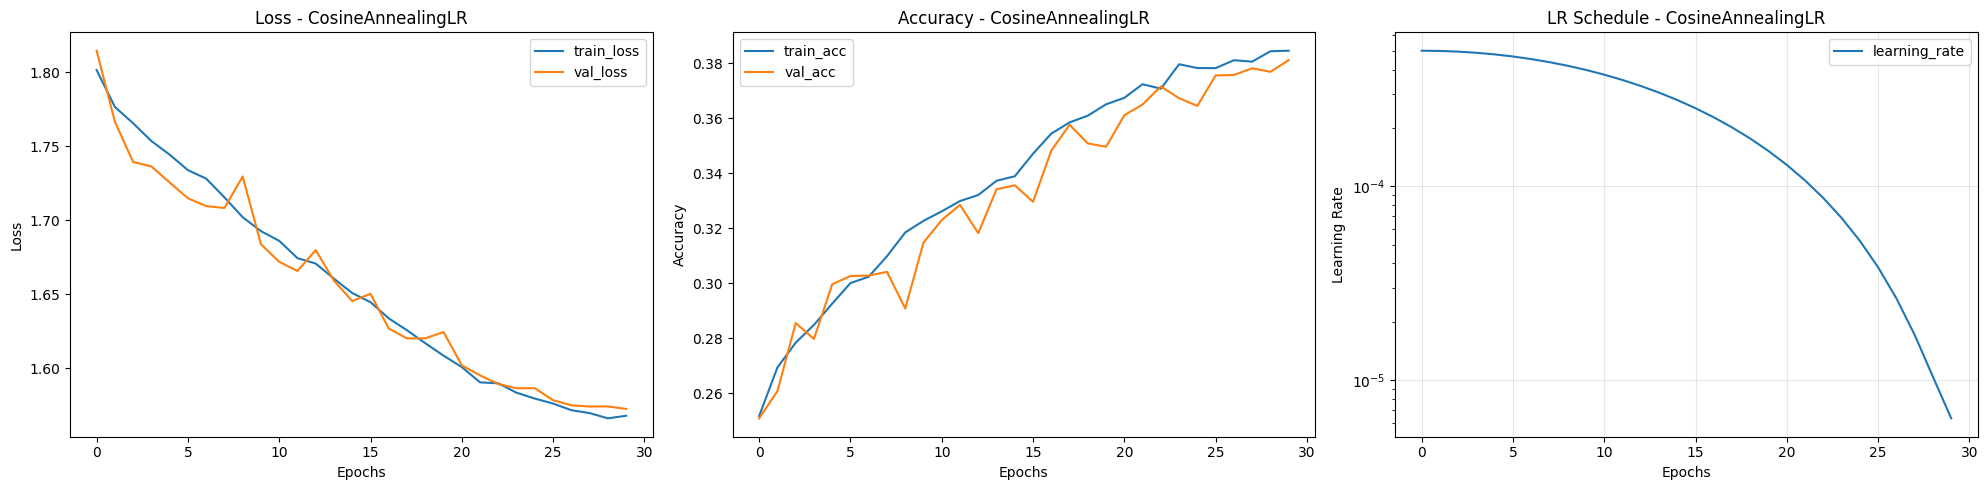



[INFO] Experiment number: 2
[INFO] Testing Optimizer: ReduceLROnPlateau
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-30/Sched_compare_ReduceLROnPlateau/baseline_cnn


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Loss: 1.8034 | Acc: 24.44% | Val Loss: 1.7704 | Val Acc: 25.84% |Lr: 5.00e-04
Epoch 2/30 | Loss: 1.7771 | Acc: 26.99% | Val Loss: 1.7585 | Val Acc: 26.71% |Lr: 5.00e-04
Epoch 3/30 | Loss: 1.7675 | Acc: 27.62% | Val Loss: 1.7478 | Val Acc: 28.39% |Lr: 5.00e-04
Epoch 4/30 | Loss: 1.7589 | Acc: 28.53% | Val Loss: 1.7481 | Val Acc: 28.37% |Lr: 5.00e-04
Epoch 5/30 | Loss: 1.7518 | Acc: 28.77% | Val Loss: 1.7481 | Val Acc: 27.63% |Lr: 5.00e-04
Epoch 6/30 | Loss: 1.7440 | Acc: 29.48% | Val Loss: 1.7292 | Val Acc: 28.93% |Lr: 5.00e-04
Epoch 7/30 | Loss: 1.7378 | Acc: 29.56% | Val Loss: 1.7341 | Val Acc: 28.14% |Lr: 5.00e-04
Epoch 8/30 | Loss: 1.7275 | Acc: 29.97% | Val Loss: 1.7373 | Val Acc: 28.91% |Lr: 5.00e-04
Epoch 9/30 | Loss: 1.7161 | Acc: 31.01% | Val Loss: 1.6983 | Val Acc: 30.69% |Lr: 5.00e-04
Epoch 10/30 | Loss: 1.7076 | Acc: 31.50% | Val Loss: 1.6915 | Val Acc: 31.02% |Lr: 5.00e-04
Epoch 11/30 | Loss: 1.6987 | Acc: 31.48% | Val Loss: 1.6843 | Val Acc: 31.79% |Lr: 5.00e-

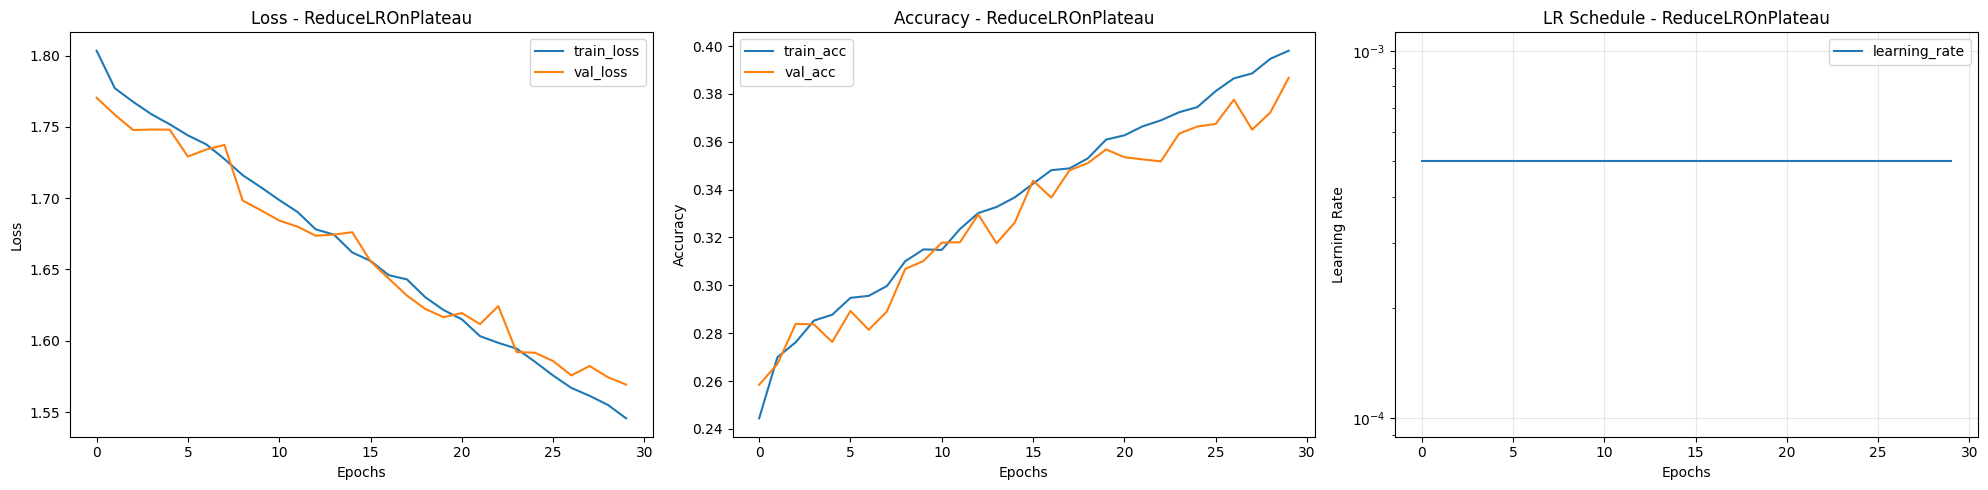



[INFO] Experiment number: 3
[INFO] Testing Optimizer: MultiStepLR
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-30/Sched_compare_MultiStepLR/baseline_cnn
Epoch 1/30 | Loss: 1.7998 | Acc: 24.62% | Val Loss: 1.7858 | Val Acc: 25.49% |Lr: 5.00e-04
Epoch 2/30 | Loss: 1.7769 | Acc: 26.86% | Val Loss: 1.7604 | Val Acc: 27.66% |Lr: 5.00e-04
Epoch 3/30 | Loss: 1.7666 | Acc: 27.81% | Val Loss: 1.7526 | Val Acc: 27.55% |Lr: 5.00e-04
Epoch 4/30 | Loss: 1.7613 | Acc: 28.31% | Val Loss: 1.7523 | Val Acc: 28.41% |Lr: 5.00e-04
Epoch 5/30 | Loss: 1.7500 | Acc: 29.05% | Val Loss: 1.7374 | Val Acc: 28.48% |Lr: 5.00e-04
Epoch 6/30 | Loss: 1.7427 | Acc: 29.47% | Val Loss: 1.7412 | Val Acc: 29.04% |Lr: 5.00e-04
Epoch 7/30 | Loss: 1.7343 | Acc: 30.02% | Val Loss: 1.7211 | Val Acc: 29.42% |Lr: 5.00e-04
Epoch 8/30 | Loss: 1.7271 | Acc: 30.26% | Val Loss: 1.7190 | Val Acc: 29.49% |Lr: 5.00e-04
Epoch 9/30 | Loss: 1.7176 | Acc: 30.66% | Val Loss: 1.

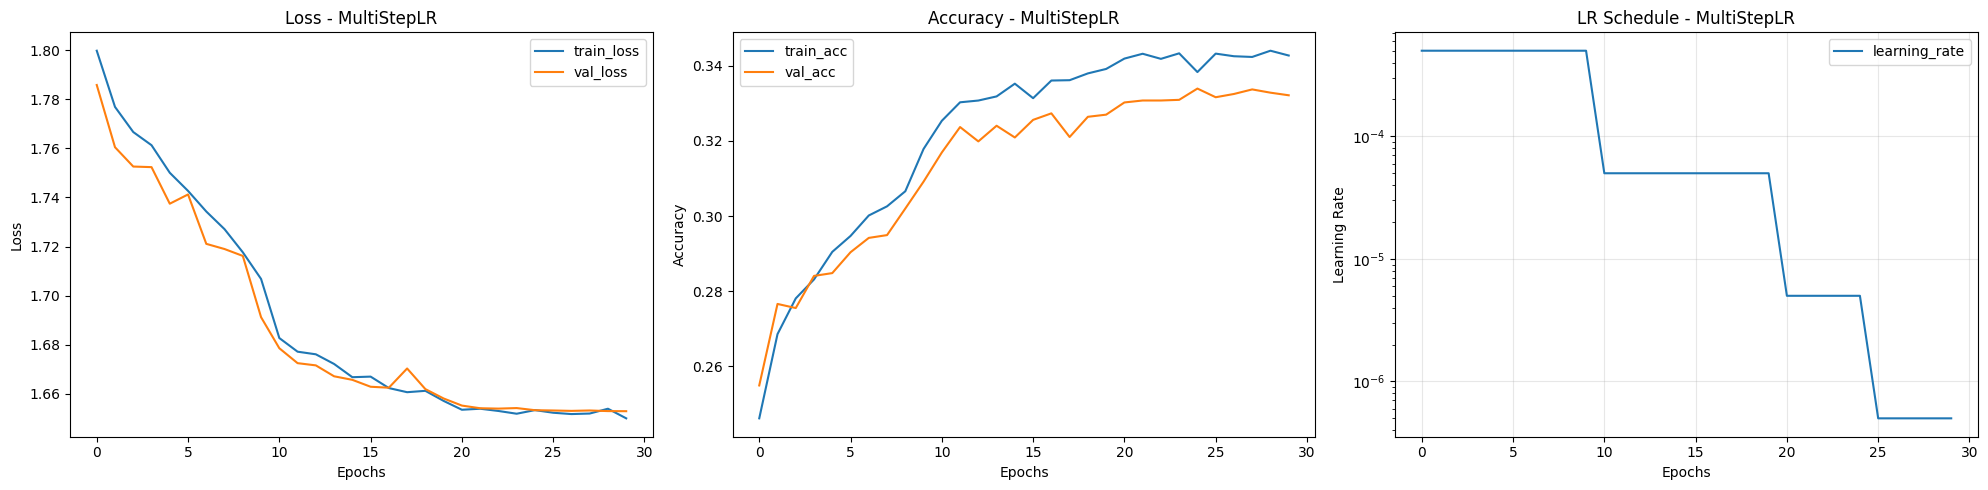

In [15]:
set_seed()
lr = 5e-4
epochs = 30

# train_dataset = TransformDataset(train_subset, train_transform_geo)
# train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
#                          pin_memory=True, num_workers=NUM_WORKERS)
scheduler_configs = {
    'CosineAnnealingLR': {
        'constructor': torch.optim.lr_scheduler.CosineAnnealingLR,
        'kwargs': {'T_max': epochs, 'eta_min': lr/100}  # T_max should be total epochs
    },
    'ReduceLROnPlateau': {
        'constructor': torch.optim.lr_scheduler.ReduceLROnPlateau,
        'kwargs': {'mode': 'min', 'patience': 5, 'factor': 0.5, 'verbose': True}  # Fixed!
    },
    'MultiStepLR': {
        'constructor': torch.optim.lr_scheduler.MultiStepLR,
        'kwargs': {'milestones': [10, 20, 25], 'gamma': 0.1, 'verbose': True}  # Added more milestones
    }
}

experiment_number = 0

for conf_name, config in scheduler_configs.items():
    # Create new model and optimizer for each experiment
    model = BaseNet(len(class_names)).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    scheduler = config['constructor'](optimizer, **config['kwargs'])
    
    experiment_number += 1
    print(f"\n[INFO] Experiment number: {experiment_number}")
    print(f"[INFO] Testing Optimizer: {conf_name}")
    print('-' * 60)

    
    results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=scheduler,
                    writer=create_writer(exp_name=f"Sched_compare_{conf_name}", model_name='baseline_cnn'))
    
    # Plot results for this experiment
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    val_loss = results['val_loss']
    val_acc = results['val_acc']
    learning_rates = results['learning_rates']
    
    epochs_ = range(len(train_loss))
    plt.figure(figsize=(20, 5))
    
    # Subplot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_, train_loss, label='train_loss')
    plt.plot(epochs_, val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss - {conf_name}')
    plt.legend()
    
    # Subplot 2: Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_, train_acc, label='train_acc')
    plt.plot(epochs_, val_acc, label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy - {conf_name}')
    plt.legend()
    
    # Subplot 3: Learning Rate Schedule (FIXED)
    plt.subplot(1, 3, 3)
    plt.plot(epochs_, learning_rates, label='learning_rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title(f'LR Schedule - {conf_name}')  # FIXED: plt.title() not plt.titlef()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('=' * 60 + '\n')


In [16]:
# Create timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
zip_name = f"tensorboard_logs_{timestamp}"

# Compress
shutil.make_archive(zip_name, 'zip', "runs")
print(f"✓ Download {zip_name}.zip from Output tab")

✓ Download tensorboard_logs_20250930_1721.zip from Output tab


## -- EVALUATION ON TEST DATA --

In [17]:
# def evaluation_step(model, test_dl, loss_fn, class_names, device):
#     model.eval()
#     test_loss, test_acc = 0, 0
#     y_true, y_pred = [], []

#     with torch.inference_mode():
#         for X, y in test_dl:
#             X, y = X.to(device), y.to(device)
#             outputs = model(X)
#             loss = loss_fn(outputs, y)
#             test_loss += loss.item()

#             preds = outputs.argmax(dim=1)
#             test_acc += (preds == y).sum().item() / len(preds)

#             y_true.extend(y.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())

#     avg_loss = test_loss / len(test_dl)
#     avg_acc = test_acc / len(test_dl)
#     test_f1 = f1_score(y_true, y_pred, average='macro')
    
#     tqdm.write(f"Test Loss: {avg_loss:.4f} | Test Acc: {avg_acc*100:.2f}% | Test F1: {test_f1:.4f}")

#     cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names_)))
    
#     disp = ConfusionMatrixDisplay(cm, display_labels=class_names_)
    
#     disp.plot(cmap='Blues', xticks_rotation=45)
#     plt.xticks(fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.tight_layout()
#     plt.show()

# evaluation_step(model, test_dl, loss_fn, class_names_, device)